In [1]:
# If deepinv cannot be found, change this to add your deepinv path
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, generate_signal, spectral_methods, cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32491 MiB free memory 


device(type='cuda', index=0)

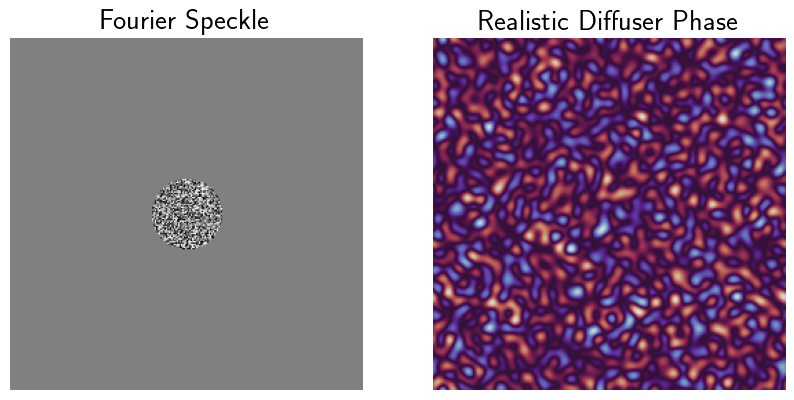

In [35]:
# Define the realistic diffuser parameters
n = 1.3 # refraction index of the lens
lambd = 532 # wavelength for green laser

n_pixels = 256

speckle_radius = 5 # defines correlation length
alpha = 6e6

# Generate the diffuser phase
fourier_speckle = np.exp(1j * 2 * np.pi * np.random.rand(n_pixels, n_pixels))
y, x = np.ogrid[-n_pixels//2:n_pixels//2, -n_pixels//2:n_pixels//2]
mask = x**2 + y**2 <= (n_pixels / speckle_radius / 2)**2

fourier_speckle = fourier_speckle * mask # define the frequencies the speckle have, large radius include more high frequencies
fourier_speckle[mask == 0] = 0 # set the rest to zero
fourier_speckle_shift = np.fft.fftshift(fourier_speckle)
z = np.fft.ifft2(fourier_speckle_shift)

h = alpha*np.real(z)
realistic_phase = (n-1) * h / lambd # computes the phase shift after the diffuser 

plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Fourier Speckle")
plt.axis('off')
plt.imshow(np.angle(fourier_speckle), cmap='grey')
plt.subplot(1, 2, 2)
plt.title("Realistic Diffuser Phase")
plt.axis('off')
plt.imshow(realistic_phase, cmap='twilight')
plt.savefig("viz-real.pdf", bbox_inches='tight', dpi=300)
plt.show()
# Convert to PyTorch tensor
#realistic_phase = torch.tensor(realistic_phase, dtype=torch.float32)
#realistic_phase = realistic_phase.unsqueeze(0)

realistic_phase = torch.tensor(realistic_phase)
realistic_phase = realistic_phase.unsqueeze(0)
# Apply complex exponential
opt_diff = np.exp(1j * realistic_phase)

config = {}
config['realistic_phase'] = opt_diff

tensor(128., device='cuda:0')


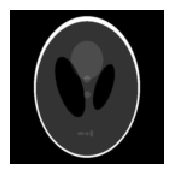

In [36]:
# Generate signal
x = generate_signal(
        shape = (1, 128, 128),
        mode = ['unit','shepp-logan'],
        phase_range=(-torch.pi/2, torch.pi/2),
        dtype=torch.complex64,
        device=device,
    )

print(x.norm())
plot(x.angle())

/home/zhhu/workspaces/deepinv/deepinv/physics/structured_random.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phase = torch.tensor(config["realistic_phase"], dtype=dtype)


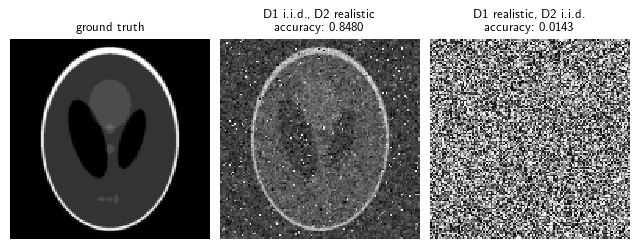

In [60]:
uni_real = dinv.physics.StructuredRandomPhaseRetrieval(
    input_shape=(1, 128, 128),
    output_shape=(1, 256, 256),
    n_layers=2,
    transforms=['fourier2'] * 2,
    diagonals= [['unit', 'uniform']] + [['marchenko', 'realistic']],  # First different, then repeat
    diagonal_config=config,
    device=device,
)

real_uni = dinv.physics.StructuredRandomPhaseRetrieval(
    input_shape=(1, 128, 128),
    output_shape=(1, 256, 256),
    n_layers=2,
    transforms=['fourier2'] * 2,
    diagonals= [['unit', 'realistic']] + [['marchenko', 'uniform']],  # First different, then repeat
    diagonal_config=config,
    device=device,
)

y1 = uni_real(x)
y2 = real_uni(x)

x1_est = spectral_methods(y1, uni_real, n_iter=5000)
x2_est = spectral_methods(y2, real_uni, n_iter=5000)

x1_est = correct_global_phase(x1_est, x)
x2_est = correct_global_phase(x2_est, x)

plot([
    x.angle(),
    x1_est.angle(),
    x2_est.angle()],
    ['ground truth',
    f'D1 i.i.d., D2 realistic\naccuracy: {cosine_similarity(x, x1_est).item():.4f}',
    f'D1 realistic, D2 i.i.d.\naccuracy: {cosine_similarity(x, x2_est).item():.4f}'
], figsize=(8,3), save_fn="real-diff-pos.pdf", dpi=300)

/home/zhhu/workspaces/deepinv/deepinv/physics/structured_random.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phase = torch.tensor(config["realistic_phase"], dtype=dtype)


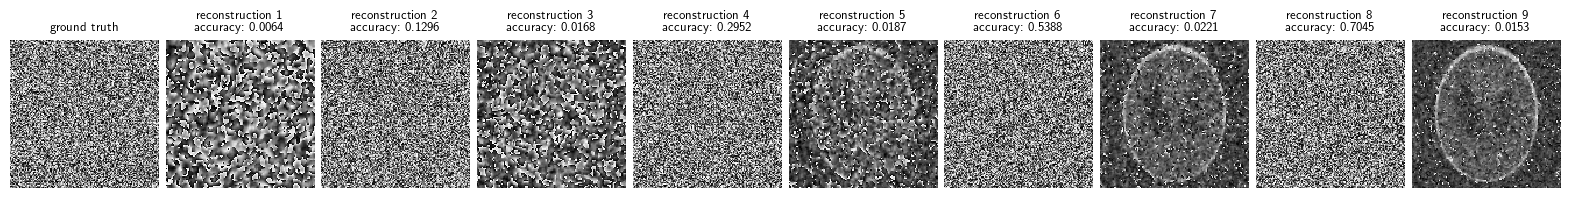

In [ ]:
recon_imgs = []

for i in range(2, 12):
    model = dinv.physics.StructuredRandomPhaseRetrieval(
        input_shape=(1, 128, 128),
        output_shape=(1, 256, 256),
        n_layers=i,
        transforms=['fourier2'] * i,
        diagonals= [['unit', 'realistic']] * (i-1) + [['marchenko', 'realistic']],
        diagonal_config=config,
        device=device,
    )
    y = model(x)
    x_est = spectral_methods(y, model, n_iter=5000)
    x_est = correct_global_phase(x_est, x)
    recon_imgs.append(x_est)

plot([img.angle() for img in recon_imgs],
     [f'reconstruction {i+1}\naccuracy: {cosine_similarity(x_est, x).item():.4f}' for i, img in enumerate(recon_imgs)], dpi=300)

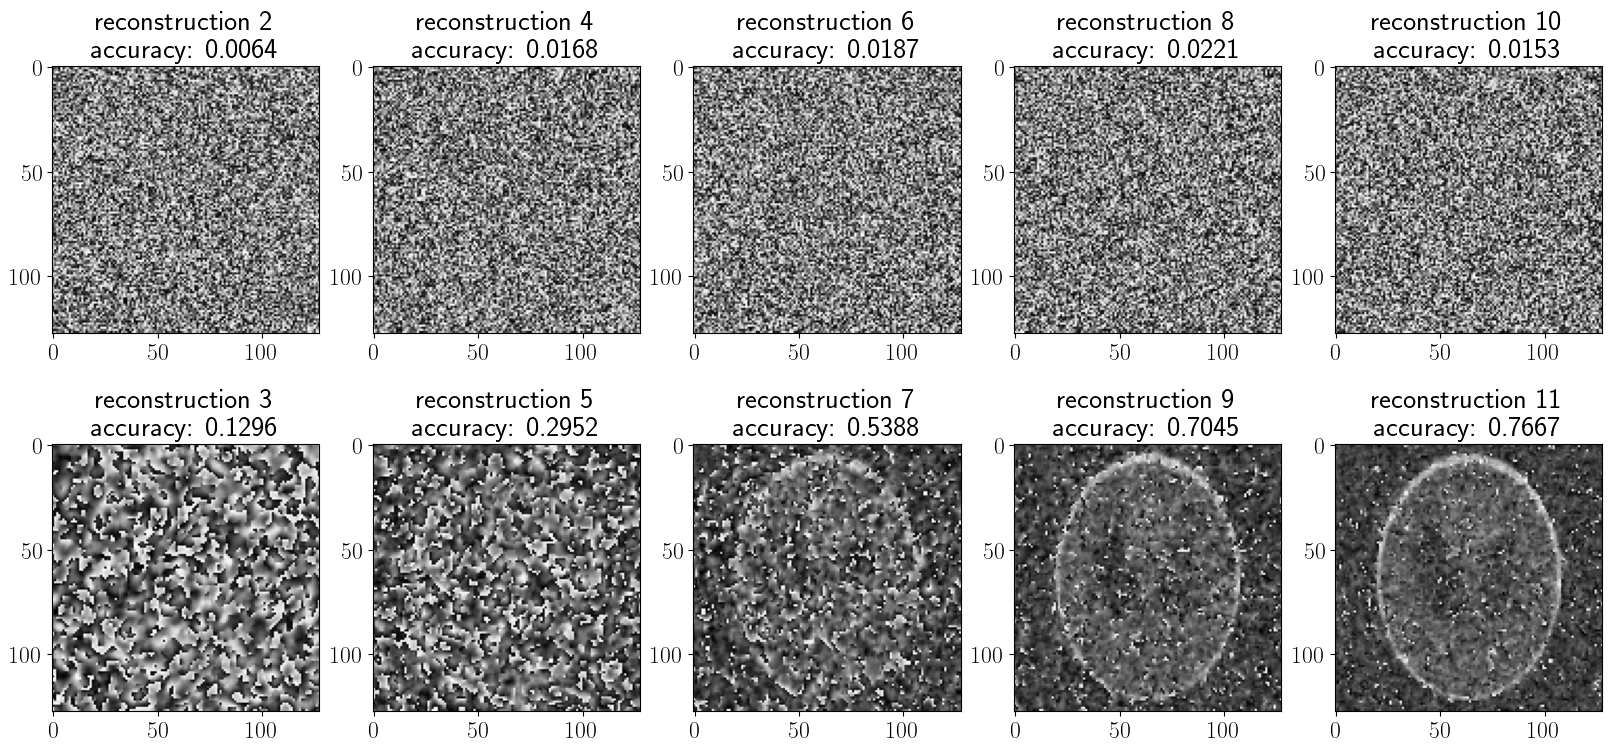

In [58]:
plt.subplots(2, 5, figsize=(20, 9))
for i in range(2, 12):
    plt.subplot(2, 5, (int(i/2) if  i%2==0 else int(i/2+4.5)))
    plt.imshow(recon_imgs[i-2][0,0].cpu().angle(), cmap='grey')
    plt.title(f'reconstruction {i}\naccuracy: {cosine_similarity(recon_imgs[i-2], x).item():.4f}')
plt.savefig("viz-real-layer.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [11]:
# Reconstruct signal
x_est = spectral_methods(y, physics, n_iter=5000)

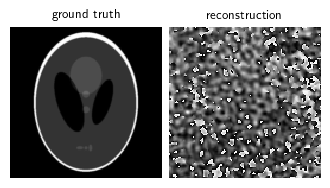

reconstruction accuracy: 0.3399
tensor([[[-0.0345, -0.1379, -0.2845,  ...,  0.0289,  0.0013,  0.0028],
         [ 0.1566,  0.0722, -0.0866,  ...,  0.0565,  0.0757,  0.1428],
         [ 0.2398,  0.2068,  0.1147,  ...,  0.0235,  0.0748,  0.1825],
         ...,
         [-0.5267, -0.5537, -0.4187,  ...,  0.3488, -0.0075, -0.3303],
         [-0.4127, -0.4688, -0.4218,  ...,  0.1611, -0.0599, -0.2662],
         [-0.2442, -0.3316, -0.3944,  ...,  0.0412, -0.0635, -0.1539]]],
       dtype=torch.float64)


In [ ]:
# Compare ground truth and reconstructed signal
x_est = correct_global_phase(x_est, x)
plot([x.angle(),x_est.angle()],['ground truth',f'reconstruction accuracy: {cosine_similarity(x, x_est).item():.4f}'])
print(f'reconstruction accuracy: {cosine_similarity(x, x_est).item():.4f}')
print(realistic_phase)

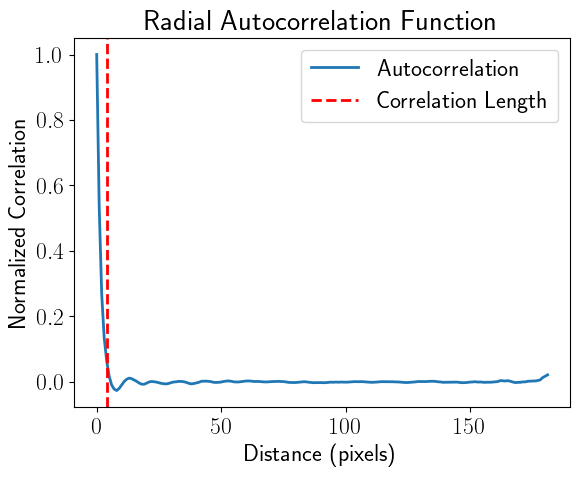

Correlation length: 4 pixels


In [14]:
import scipy.ndimage
phase_np = np.mod(realistic_phase.squeeze().numpy(), 2*np.pi)

# Compute the 2D autocorrelation function
def autocorrelation_2d(image):
    """Compute the 2D autocorrelation of an image."""
    image -= np.mean(image)  # Remove mean
    corr = np.fft.ifft2(np.abs(np.fft.fft2(image))**2).real #convolution (shifting) in Fourier space
    corr = np.fft.fftshift(corr)  # Center the correlation
    corr /= corr.max()  # Normalize
    return corr

corr = autocorrelation_2d(phase_np)

# Compute radial profile
y, x = np.indices(corr.shape)
center = np.array(corr.shape) // 2
r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
r = r.astype(int)

tbin = np.bincount(r.ravel(), weights=corr.ravel())
nr = np.bincount(r.ravel())
radial_profile = tbin / nr

# Find correlation length (first x where radial_profile reaches 0)
correlation_length = np.argmax(radial_profile <= 0.1)

import matplotlib.pyplot as plt
plt.plot(radial_profile, label="Autocorrelation")
plt.axvline(correlation_length, color='r', linestyle='--', label="Correlation Length")
plt.xlabel("Distance (pixels)")
plt.ylabel("Normalized Correlation")
plt.title("Radial Autocorrelation Function")
plt.legend()
plt.show()

print(f"Correlation length: {correlation_length} pixels")

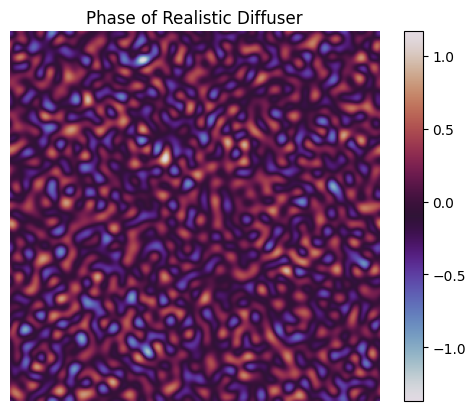

In [8]:
# Assuming realistic_phase is already a tensor
realistic_phase_np = realistic_phase.squeeze().numpy()  # Remove batch dimension if needed

# Plot the phase
plt.imshow(realistic_phase_np, cmap='twilight')  # 'twilight' is good for cyclic data like phase
plt.colorbar()
plt.title('Phase of Realistic Diffuser')
plt.axis('off')
plt.savefig('../figures/realistic_phase.pdf', dpi=300, bbox_inches='tight')
plt.show()

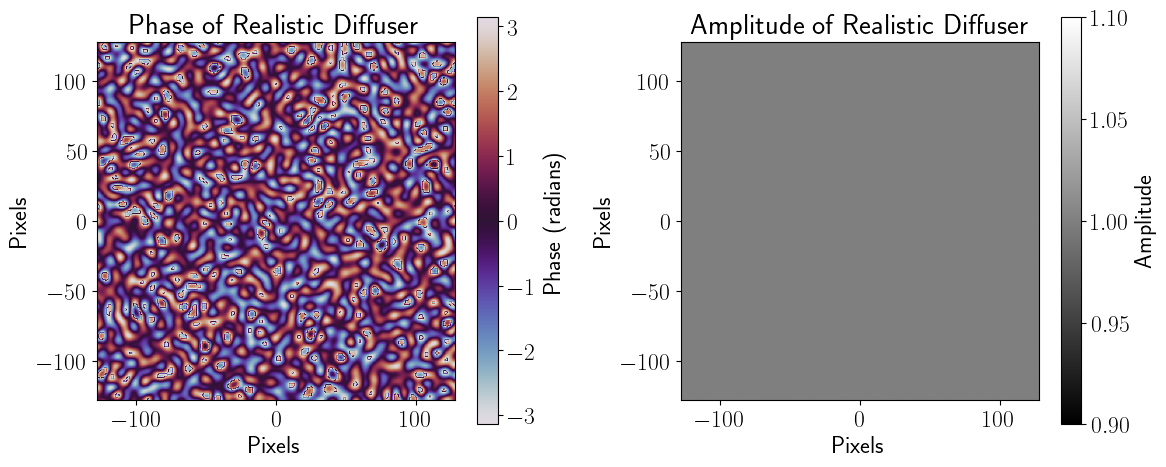

In [16]:
opt_diff_np = opt_diff.squeeze(0).numpy()
phase = np.angle(opt_diff_np)
amplitude = np.abs(opt_diff_np)

# Plot phase
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(phase, cmap='twilight', extent=[-n_pixels//2, n_pixels//2, -n_pixels//2, n_pixels//2])
plt.colorbar(label="Phase (radians)")
plt.title("Phase of Realistic Diffuser")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

# Plot amplitude
plt.subplot(1, 2, 2)
plt.imshow(amplitude, cmap='gray', extent=[-n_pixels//2, n_pixels//2, -n_pixels//2, n_pixels//2])
plt.colorbar(label="Amplitude")
plt.title("Amplitude of Realistic Diffuser")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.tight_layout()
plt.show()

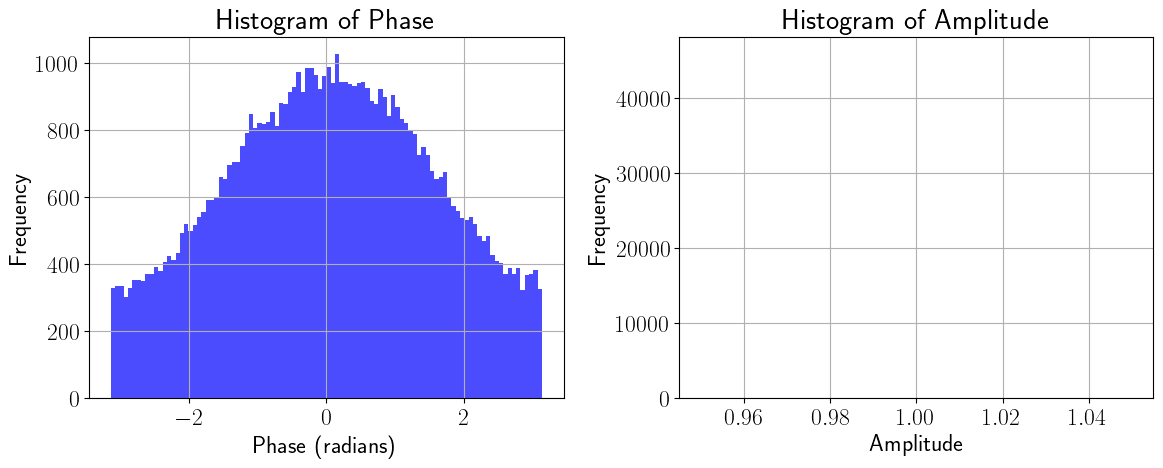

In [17]:
# Create figure with subplots
plt.figure(figsize=(12, 5))

# Histogram of Phase
plt.subplot(1, 2, 1)
plt.hist(phase.flatten(), bins=100, color='blue', alpha=0.7)
plt.xlabel("Phase (radians)")
plt.ylabel("Frequency")
plt.title("Histogram of Phase")
plt.grid(True)

# Histogram of Amplitude
plt.subplot(1, 2, 2)
plt.hist(amplitude.flatten(), bins=100, color='red', alpha=0.7)
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.title("Histogram of Amplitude")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()